In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tldextract
import wordninja
import pickle

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

# Грузим данные

In [2]:
data = pd.read_csv('big_dataset', sep='\t', header=None, names=['url', 'target'])

In [3]:
data = shuffle(data)
data.reset_index(inplace=True, drop=True)
data

,url,target
0,bcegjkbeggjm.info,1
1,farmandfleet.com,0
2,sought-perl.pro,1
3,hofunokpicm.kz,1
4,datasysco.ir,0
...,...,...
25995,ymdiestnessbiophysicalohax.com,1
25996,kkbluxexnbhejavnmkfy.com,1
25997,mswxtlhqor.cc,1
25998,skrynya.ua,0


# Экстраким фичи 

### Длинна 

In [4]:
data['len'] = data.url.apply(lambda x: len(x))

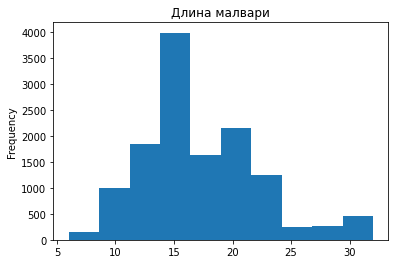

In [5]:
data[data.target == 1].len.plot(kind='hist', title="Длина малвари");

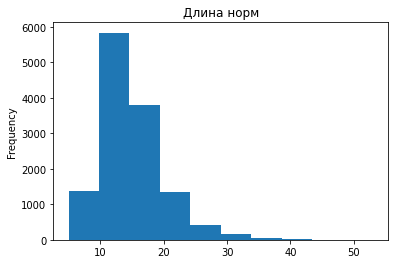

In [6]:
data[data.target == 0].len.plot(kind='hist', title="Длина норм");

### TLD и домены

In [7]:
tldextract.extract(data.url[3]) 

ExtractResult(subdomain='', domain='hofunokpicm', suffix='kz')

In [8]:
data['suffixes'] = data.url.apply(lambda url: tldextract.extract(url).suffix)
data['domains'] = data.url.apply(lambda url: tldextract.extract(url).domain)
data

,url,target,len,suffixes,domains
0,bcegjkbeggjm.info,1,17,info,bcegjkbeggjm
1,farmandfleet.com,0,16,com,farmandfleet
2,sought-perl.pro,1,15,pro,sought-perl
3,hofunokpicm.kz,1,14,kz,hofunokpicm
4,datasysco.ir,0,12,ir,datasysco
...,...,...,...,...,...
25995,ymdiestnessbiophysicalohax.com,1,30,com,ymdiestnessbiophysicalohax
25996,kkbluxexnbhejavnmkfy.com,1,24,com,kkbluxexnbhejavnmkfy
25997,mswxtlhqor.cc,1,13,cc,mswxtlhqor
25998,skrynya.ua,0,10,ua,skrynya


### Гласные/согласные/цифры

In [9]:
def get_vowels(word):
    vowels = set('aeiou')  
    result = {
        #'vowels_count': 0, 
        'consonants_count': 0,
        'number_count': 0
    }
    for letter in word.lower():
        if letter in vowels:
            #result['vowels_count'] += 1
            pass
        elif letter.isdigit():
            result['number_count'] += 1
        else:
            result['consonants_count'] += 1
    return result
            

In [10]:
words_info_df = pd.DataFrame.from_records(data.domains.apply(get_vowels).values)

In [11]:
words_info_df

,consonants_count,number_count
0,10,0
1,8,0
2,8,0
3,7,0
4,6,0
...,...,...
25995,17,0
25996,16,0
25997,9,0
25998,6,0


In [12]:
data = pd.concat([data, words_info_df], axis=1)

In [13]:
def get_domain_words_len(domain):
    words = wordninja.split(domain)
    return {'domain_words_len': len(words)}

In [14]:
domain_words_df = pd.DataFrame.from_records(data.domains.apply(get_domain_words_len).values)
domain_words_df

,domain_words_len
0,6
1,3
2,2
3,5
4,3
...,...
25995,9
25996,9
25997,6
25998,3


In [15]:
data = pd.concat([data, domain_words_df], axis=1)

In [16]:
data

,url,target,len,suffixes,domains,consonants_count,number_count,domain_words_len
0,bcegjkbeggjm.info,1,17,info,bcegjkbeggjm,10,0,6
1,farmandfleet.com,0,16,com,farmandfleet,8,0,3
2,sought-perl.pro,1,15,pro,sought-perl,8,0,2
3,hofunokpicm.kz,1,14,kz,hofunokpicm,7,0,5
4,datasysco.ir,0,12,ir,datasysco,6,0,3
...,...,...,...,...,...,...,...,...
25995,ymdiestnessbiophysicalohax.com,1,30,com,ymdiestnessbiophysicalohax,17,0,9
25996,kkbluxexnbhejavnmkfy.com,1,24,com,kkbluxexnbhejavnmkfy,16,0,9
25997,mswxtlhqor.cc,1,13,cc,mswxtlhqor,9,0,6
25998,skrynya.ua,0,10,ua,skrynya,6,0,3


### Ф-ция для превращения списка ссылок в фичи

In [17]:
def convert_to_features(urls: list):
    result_rows = []
    for url in urls:
        domain_cut = tldextract.extract(url).domain
        url_row = get_vowels(domain_cut)
        #del url_row['vowels_count']
        url_row['len'] = len(domain_cut)
        url_row['domain_words_len'] = get_domain_words_len(domain_cut)['domain_words_len']
        result_rows.append(url_row)
    return pd.DataFrame.from_records(result_rows)

# Делим датасет

In [18]:
#X = data[['len', 'vowels_count', 'consonants_count', 'number_count', 'domain_words_len']]
X = data[['len', 'consonants_count', 'number_count', 'domain_words_len']]
y = data.target

In [19]:
X

,len,consonants_count,number_count,domain_words_len
0,17,10,0,6
1,16,8,0,3
2,15,8,0,2
3,14,7,0,5
4,12,6,0,3
...,...,...,...,...
25995,30,17,0,9
25996,24,16,0,9
25997,13,9,0,6
25998,10,6,0,3


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

## KNN (baseline)

In [21]:
KNN = KNeighborsClassifier(n_neighbors=15)

In [22]:
KNN = pickle.load(open('KNN_model.sav', 'rb'))

In [23]:
scoring = ['accuracy', 'roc-auc']

In [24]:
scores = cross_val_score(KNN, X, y, cv=10, scoring='roc_auc')
acc_scores = cross_val_score(KNN, X, y, cv=10, scoring='accuracy')
print(acc_scores.mean())

0.8682692307692308


In [25]:
scores.mean()

0.9393958284023668

In [26]:
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [27]:
pickle.dump(KNN, open('KNN_model.sav', 'wb'))

In [28]:
our_test_data = [
    'saber.nya.pub',
    'google.com',
    'ya.ru',
    'yandex.ru',
    'wikipedia.org',
    'sabertracker.ga',
    'thfuckginmalwarecomsomefag.com',
    '1x-bet82717.com',
    'qds1g7xhh83l1frai5d1kzjmoj.org',
    'e9wfnu20nspn1aq4zjybwyu3m.com',
    'alllawstheheagesusurpations.com'
]
our_y = convert_to_features(our_test_data)
for a, b in zip(range(len(our_test_data)), our_test_data):
    print(f'{a}: {b}')
our_y

0: saber.nya.pub
1: google.com
2: ya.ru
3: yandex.ru
4: wikipedia.org
5: sabertracker.ga
6: thfuckginmalwarecomsomefag.com
7: 1x-bet82717.com
8: qds1g7xhh83l1frai5d1kzjmoj.org
9: e9wfnu20nspn1aq4zjybwyu3m.com
10: alllawstheheagesusurpations.com


,consonants_count,number_count,len,domain_words_len
0,2,0,3,1
1,3,0,6,1
2,1,0,2,1
3,4,0,6,3
4,4,0,9,1
5,8,0,12,2
6,17,0,26,8
7,4,6,11,4
8,16,7,26,17
9,15,6,25,18


In [29]:
KNN.predict(our_y)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

## <span style="color:green">Пробуем деревья </span> 🌲

In [30]:
DTreeClassifier = DecisionTreeClassifier(splitter='best')

In [31]:
DTreeClassifier = pickle.load(open('DTreeClassifier_model.sav', 'rb'))

In [32]:
scores = cross_val_score(DTreeClassifier, X, y, cv=5, scoring='roc_auc')
acc_scores = cross_val_score(DTreeClassifier, X, y, cv=5, scoring='accuracy')
print(acc_scores.mean())

0.8737307692307692


In [33]:
scores.mean()

0.9384683284023669

In [34]:
DTreeClassifier.fit(X_train, y_train)
DTreeClassifier.predict(our_y)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [35]:
pickle.dump(DTreeClassifier, open('DTreeClassifier_model.sav', 'wb'))

## SVM

In [36]:
clf = SVC(C=10, class_weight='balanced')

In [37]:
clf = pickle.load(open('clf_model.sav', 'rb'))

In [38]:
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

In [39]:
scores.mean()

0.9177438461538461

In [40]:
clf.fit(X_train, y_train)
clf.predict(our_y)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [41]:
pickle.dump(clf, open('clf_model.sav', 'wb'))

## Logistic Regression

In [42]:
lr = LogisticRegression(solver='liblinear', penalty='l2' , multi_class='ovr')


In [43]:
lr = pickle.load(open('lr_model.sav', 'rb'))

In [44]:
scores = cross_val_score(lr, X, y, cv=5, scoring='roc_auc')

In [45]:
scores.mean()

0.8470047928994082

In [46]:
lr.fit(X_train, y_train)
lr.predict(our_y)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

In [47]:
pickle.dump(lr, open('lr_model.sav', 'wb'))

## Cлучайный лес

In [48]:
rf = RandomForestClassifier(n_estimators=25, random_state=128)

In [49]:
rf = pickle.load(open('rf_model.sav', 'rb'))

In [50]:
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

In [51]:
scores.mean()

0.944620325443787

In [52]:
rf.fit(X_train, y_train)
rf.predict(our_y)

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [53]:
pickle.dump(rf, open('rf_model.sav', 'wb'))

# Корреляция

In [54]:
data.corr()

,target,len,consonants_count,number_count,domain_words_len
target,1.000000,0.230374,0.256043,0.147209,0.557755
len,0.230374,1.000000,0.605319,0.124469,0.402520
consonants_count,0.256043,0.605319,1.000000,-0.229173,0.630168
number_count,0.147209,0.124469,-0.229173,1.000000,0.213982
domain_words_len,0.557755,0.402520,0.630168,0.213982,1.000000


# Kaggle verified TM :) (ансамбли) 

In [55]:
reg = lgb.LGBMClassifier(boosting_type="rf",
                         num_leaves=150,
                         colsample_bytree=1,
                         n_estimators=18,
                         min_child_weight=0.1,
                         objective='binary',
                         min_child_samples=5,
                         subsample=.632,
                         subsample_freq=1,
                         min_split_gain=0,
                         reg_lambda=0, # L2 regularization
                         n_jobs=-1)

In [56]:
reg = pickle.load(open('lgb_model.sav', 'rb'))

In [57]:
scores = cross_val_score(reg, X, y, cv=10, scoring='roc_auc')
scores.mean()

0.9483237278106509

In [ ]:
for leaves_n in range(90, 210, 15):
    reg = lgb.LGBMClassifier(boosting_type="gbdt",
                         num_leaves=leaves_n,
                         colsample_bytree=1,
                         n_estimators=18,
                         min_child_weight=0.1,
                         objective='binary',
                         min_child_samples=5,
                         subsample=1,
                         subsample_freq=1,
                         min_split_gain=0,
                         reg_lambda=0, # L2 regularization
                         n_jobs=-1)
    scores = cross_val_score(reg, X, y, cv=10, scoring='roc_auc')
    print(f'При {leaves_n} листьях скор = {scores.mean()}')

При 90 листьях скор = 0.9478655325443788
При 105 листьях скор = 0.9481368934911242
При 120 листьях скор = 0.9484836686390533
При 135 листьях скор = 0.948764171597633
При 150 листьях скор = 0.9487884911242602
При 165 листьях скор = 0.948739674556213
При 180 листьях скор = 0.9484739940828403


In [ ]:
reg.fit(X, y)

In [ ]:
reg.predict(our_y)

In [ ]:
pickle.dump(reg, open('lgb_model.sav', 'wb'))

In [ ]:
data_test = data

In [ ]:
data_test['y_pred'] = reg.predict(X)

In [ ]:
data_test[['url', 'target', 'y_pred']][data.target != data.y_pred]

In [ ]:
data_test[['url', 'target', 'y_pred']][data.target != data.y_pred].target.sum()